In [1]:
import sys
import os
from dotenv import load_dotenv

sys.path.append(os.path.abspath('src'))

In [2]:
import SoccerNet
from SoccerNet.Downloader import SoccerNetDownloader

mySoccerNetDownloader=SoccerNetDownloader(LocalDirectory="SoccerNet")
load_dotenv()
mySoccerNetDownloader.password = os.getenv("SOCCERNET_KEY")

# # Downloading the annotations of the 500 games
# mySoccerNetDownloader.downloadGames(files=["Labels-v2.json"], split=["train","valid","test"])

# mySoccerNetDownloader.downloadGames(files=["1_ResNET_TF2_PCA512.npy", "2_ResNET_TF2_PCA512.npy"], split=["train","valid","test","challenge"])

In [3]:
from utils import Utilities
utilities = Utilities("SoccerNet")

# utilities.save_labels_in_csv()

In [4]:
from data_loading import DataLoading

batch_size = 32
fps = 2
chunk_length = 60

train_dataloading = DataLoading("SoccerNet", fps, chunk_length, batch_size, split_type="train", context_aware=False)
val_dataloading = DataLoading("SoccerNet", fps, chunk_length, batch_size, split_type="valid", context_aware=False)

train_loader = train_dataloading.get_dataloader()
val_loader = val_dataloading.get_dataloader()


In [5]:
import torch
from torch.utils.data import DataLoader
from context_aware_loss import TemporalSegmentationLoss
import model
import numpy as np

from training import Trainer

classifier = model.Model(input_dim=512, num_classes=17)


Loss function in use: <class 'torch.nn.modules.loss.BCELoss'>


In [6]:
trainer = Trainer(classifier, train_loader, val_loader, epochs=200, batch_size=batch_size, prediction_threshold=0.5, context_aware=False)
trainer.load_checkpoint("weights/model_0_2.pth")

c:\Users\justi\Documents\TRAVAIL\Porto\Deep Learning\TAAC_project\src\training.py:126: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(file_path)


In [7]:
# trainer.train()

In [8]:
# trainer.plot_training_loss()
# trainer.save_checkpoint("weights/model_0_3.pth")

In [9]:
from event_spotting import EventSpotter

test_dataloading = DataLoading("SoccerNet", 1, chunk_length=1, batch_size=1, split_type="test")

(5400, 512)
(5400, 17)
[[  6.500095   -10.232788    13.768982   ...  -0.39546517   0.5537336
   -0.4141675 ]
 [ 10.23063    -10.377187    10.965774   ...  -0.63641405   0.7312847
   -0.5103248 ]
 [ 10.127903    -9.7196      10.979615   ...  -0.5280806    0.4497399
   -0.32734787]
 [ 13.272164   -10.959559     8.427803   ...  -0.22308798   0.43073413
   -0.40579188]
 [ 14.630885    -6.7566323    7.3896713  ...  -0.2651968    0.6953006
   -0.30757117]]
[[0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
[2.099919038300868e-05, 1.913415326271206e-05, 5.1002604917194105e-11, 8.923983219055742e-10, 4.2853880586335436e-05, 4.4601773652175325e-07, 4.1138457163469866e-05, 0.9999978542327881, 6.390751423168695e-06, 6.555984921607916e-12, 7.223745797091397e-07, 1.6701388716455767e-08, 1.6834198959259083e-06, 0.023425262421369553, 2.935892916866578e-05, 6.467072671

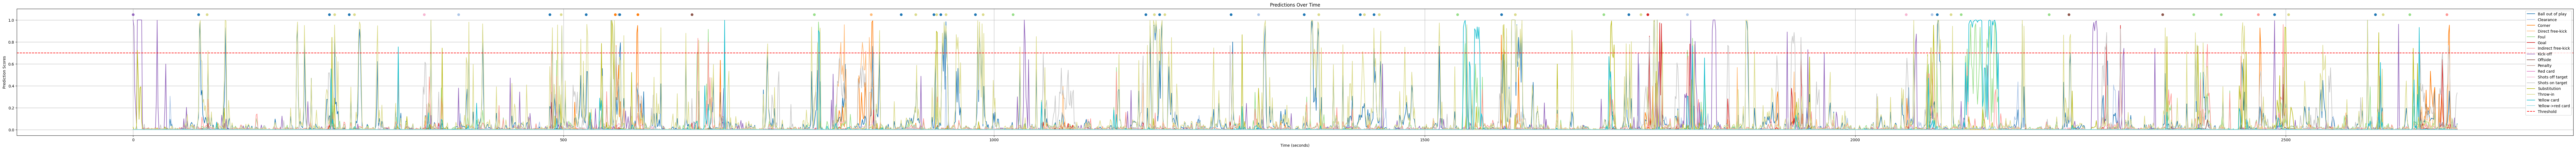

In [10]:
video_name = test_dataloading.video_names[0]

features, labels = test_dataloading.load_features_labels(video_name, half=1)

print(features.shape)
print(labels.shape)

print(features[:5])
print(labels[:5])

event_spotter = EventSpotter(model=classifier, fps=fps, detection_threshold=0.7, nms_window=60, delta=360)

event_spotter.detect_events(features)

raw_predictions = event_spotter.get_predictions()
final_events = event_spotter.get_events()

ground_truth = {i: labels[i] for i in range(len(labels))}  # Format ground truth
print(f"Ground truth: {ground_truth}")
evaluation = event_spotter.evaluate_predictions(ground_truth)

print("Raw Predictions:", raw_predictions)
print("Final Detected Events:", final_events)
print("Evaluation Metrics:", evaluation)

event_spotter.show_predictions_summary(ground_truth, True)

In [11]:
# Downloading the videos of the 500 games
# mySoccerNetDownloader.downloadGames(files=["1_224p.mkv", "2_224p.mkv"], split=["train","valid","test","challenge"])

In [12]:
import pandas as pd
from IPython.display import display
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
pd.set_option('display.max_rows', 20)
pd.set_option('display.colheader_justify', 'center')

annotations_df = utilities.parse_labels_json()
annotations_engineered_df = utilities.parse_labels_json_with_feature_engineering()

display(annotations_df.head())
annotations_df.to_csv("annotations.csv", index=False)

display(annotations_engineered_df.head(100))
annotations_engineered_df.to_csv("annotations_engineered.csv", index=False)

AttributeError: 'Utilities' object has no attribute 'parse_labels_json'

In [ ]:
print("Number of rows:", annotations_engineered_df.shape[0])
print("Number of columns:", annotations_engineered_df.shape[1])

In [ ]:
print("DataFrame Info:")
print(annotations_engineered_df.info())

In [ ]:
print("Missing Values per Column:")
print(annotations_engineered_df.isnull().sum())


In [ ]:
print("Descriptive Statistics (Including Non-Numerical):")
display(annotations_engineered_df.describe(include='all'))

In [ ]:
# Number of unique labels (excluding game-related columns)
label_columns = [col for col in annotations_engineered_df.columns if col.startswith('label_')]
unique_labels = len(label_columns)
print("Number of unique labels:", unique_labels)

# List of unique labels (based on the column names)
print("Unique labels:", label_columns)


In [ ]:
utilities.print_labels_distribution(annotations_engineered_df)

In [ ]:
utilities.print_labels_frequency(annotations_engineered_df)

In [ ]:
utilities.print_labels_frequency_per_league(annotations_engineered_df)

In [ ]:
utilities.print_labels_distribution_over_game_intervals(annotations_engineered_df)